# BäräRallye – Wochen-Simulation

Dieses Notebook simuliert eine Woche Fahrten für die Personas **Sandro, Luca, Aylin und Ursula**.
Alle Werte (km, Punkte, CO₂) sind auf **1 Dezimalstelle** gerundet.

Am Ende gibt es zusätzlich **Diagramme** für Leaderboard und CO₂-Ersparnis.

## 1. Imports & Haversine

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

## 2. GPS-Haltestellen

In [2]:
stops = {
    'bern_unitobler': (46.95685, 7.43144),
    'bern_bollwerk': (46.95, 7.4333),
    'bern_ka_wede': (46.935303, 7.447068),
    'bern_bahnhof': (46.950497, 7.438109),
    'bern_baerenplatz': (46.947472, 7.443583),
    'bern_rathaus': (46.94875, 7.452389),
    'bern_bundesplatz': (46.94731, 7.44402),
    'bern_ostring': (46.945, 7.472),
    'bern_viktoriaplatz': (46.95494, 7.45170),
    'koeniz_schliern': (46.933, 7.4),
    'koeniz_bruehlplatz': (46.9265957, 7.4173095),
    'buempliz': (46.940063, 7.3902924),
    'bruennen_westside': (46.94403694, 7.37527806),
    'wankdorf': (46.96781889, 7.465465)
}
stops

{'bern_unitobler': (46.95685, 7.43144),
 'bern_bollwerk': (46.95, 7.4333),
 'bern_ka_wede': (46.935303, 7.447068),
 'bern_bahnhof': (46.950497, 7.438109),
 'bern_baerenplatz': (46.947472, 7.443583),
 'bern_rathaus': (46.94875, 7.452389),
 'bern_bundesplatz': (46.94731, 7.44402),
 'bern_ostring': (46.945, 7.472),
 'bern_viktoriaplatz': (46.95494, 7.4517),
 'koeniz_schliern': (46.933, 7.4),
 'koeniz_bruehlplatz': (46.9265957, 7.4173095),
 'buempliz': (46.940063, 7.3902924),
 'bruennen_westside': (46.94403694, 7.37527806),
 'wankdorf': (46.96781889, 7.465465)}

## 3. Wochenfahrten definieren

In [12]:
weekly_trips = [
    {"user": "Sandro", "from": "bern_unitobler", "to": "bern_bollwerk", "roundtrips": 4},
    {"user": "Sandro", "from": "bern_unitobler", "to": "bern_ka_wede", "roundtrips": 1},

    {"user": "Luca", "from": "koeniz_schliern", "to": "bern_baerenplatz", "roundtrips": 5},
    {"user": "Luca", "from": "koeniz_schliern", "to": "koeniz_bruehlplatz", "roundtrips": 2},
    {"user": "Luca", "from": "koeniz_schliern", "to": "wankdorf", "roundtrips": 1},

    {"user": "Aylin", "from": "buempliz", "to": "bern_bahnhof", "roundtrips": 3},
    {"user": "Aylin", "from": "buempliz", "to": "bern_rathaus", "roundtrips": 1},
    {"user": "Aylin", "from": "buempliz", "to": "bruennen_westside", "roundtrips": 1},

    {"user": "Ursula", "from": "bern_ostring", "to": "bern_bundesplatz", "roundtrips": 1},
    {"user": "Ursula", "from": "bern_ostring", "to": "bern_viktoriaplatz", "roundtrips": 1},
]
weekly_trips

[{'user': 'Sandro',
  'from': 'bern_unitobler',
  'to': 'bern_bollwerk',
  'roundtrips': 4},
 {'user': 'Sandro',
  'from': 'bern_unitobler',
  'to': 'bern_ka_wede',
  'roundtrips': 1},
 {'user': 'Luca',
  'from': 'koeniz_schliern',
  'to': 'bern_baerenplatz',
  'roundtrips': 5},
 {'user': 'Luca',
  'from': 'koeniz_schliern',
  'to': 'koeniz_bruehlplatz',
  'roundtrips': 2},
 {'user': 'Luca',
  'from': 'koeniz_schliern',
  'to': 'wankdorf',
  'roundtrips': 1},
 {'user': 'Aylin', 'from': 'buempliz', 'to': 'bern_bahnhof', 'roundtrips': 3},
 {'user': 'Aylin', 'from': 'buempliz', 'to': 'bern_rathaus', 'roundtrips': 1},
 {'user': 'Aylin',
  'from': 'buempliz',
  'to': 'bruennen_westside',
  'roundtrips': 1},
 {'user': 'Ursula',
  'from': 'bern_ostring',
  'to': 'bern_bundesplatz',
  'roundtrips': 1},
 {'user': 'Ursula',
  'from': 'bern_ostring',
  'to': 'bern_viktoriaplatz',
  'roundtrips': 1}]

## 4. Berechnung (km, Punkte, CO₂)

In [13]:
POINTS_PER_KM = 1
CO2_PER_KM_G = 162 #laut EnergieSchweiz Umweltrechner, Vergleich öffentlicher Verkehr mit Auto (Flottendurchschnitt). https://www.energieschweiz.ch/programme/umweltrechner-verkehr/
rows = []
for trip in weekly_trips:
    lat1, lon1 = stops[trip['from']]
    lat2, lon2 = stops[trip['to']]
    one_way = haversine_km(lat1, lon1, lat2, lon2)
    roundtrip = one_way * 2
    total_km = roundtrip * trip['roundtrips']

    rows.append({
        'user': trip['user'],
        'from': trip['from'],
        'to': trip['to'],
        'roundtrips': trip['roundtrips'],
        'one_way_km': round(one_way, 1),
        'total_km': round(total_km, 1),
        'points': round(total_km * POINTS_PER_KM, 1),
        'co2_saved_kg': round(total_km * CO2_PER_KM_G / 1000, 1)
    })

df_trips = pd.DataFrame(rows)
df_trips

user             from                  to  roundtrips  one_way_km  \
0  Sandro   bern_unitobler       bern_bollwerk           4         0.8   
1  Sandro   bern_unitobler        bern_ka_wede           1         2.7   
2    Luca  koeniz_schliern    bern_baerenplatz           5         3.7   
3    Luca  koeniz_schliern  koeniz_bruehlplatz           2         1.5   
4    Luca  koeniz_schliern            wankdorf           1         6.3   
5   Aylin         buempliz        bern_bahnhof           3         3.8   
6   Aylin         buempliz        bern_rathaus           1         4.8   
7   Aylin         buempliz   bruennen_westside           1         1.2   
8  Ursula     bern_ostring    bern_bundesplatz           1         2.1   
9  Ursula     bern_ostring  bern_viktoriaplatz           1         1.9   

   total_km  points  co2_saved_kg  
0       6.2     6.2           1.0  
1       5.3     5.3           0.9  
2      36.8    36.8           6.0  
3       6.0     6.0           1.0  
4      12.6    12.6           2.0  
5      22.9    22.9           3.7  
6       9.6     9.6           1.6  
7       2.4     2.4           0.4  
8       4.3     4.3           0.7  
9       3.8     3.8           0.6

## 5. Simulationswoche Gesamtsummen & Leaderboard

In [16]:
weekly_totals = (
    df_trips.groupby('user', as_index=False)
            .agg(total_km=('total_km', 'sum'),
                 total_points=('points', 'sum'),
                 total_co2_saved_kg=('co2_saved_kg', 'sum'))
)

weekly_totals['total_km'] = weekly_totals['total_km'].round(1)
weekly_totals['total_points'] = weekly_totals['total_points'].round(1)
weekly_totals['total_co2_saved_kg'] = weekly_totals['total_co2_saved_kg'].round(1)

weekly_totals = weekly_totals.sort_values('total_points', ascending=False).reset_index(drop=True)
weekly_totals

user  total_km  total_points  total_co2_saved_kg
0    Luca      55.4          55.4                 9.0
1   Aylin      34.9          34.9                 5.7
2  Sandro      11.5          11.5                 1.9
3  Ursula       8.1           8.1                 1.3

## 6. Challenges

In [17]:
WEEKLY_KM_TARGET = 25
TOP_N = 2

weekly_totals['rank'] = weekly_totals['total_points'].rank(ascending=False, method='min').astype(int)
weekly_totals['meets_weekly_challenge'] = weekly_totals['total_km'] >= WEEKLY_KM_TARGET
weekly_totals['meets_top_rank_challenge'] = weekly_totals['rank'] <= TOP_N

weekly_totals

user  total_km  total_points  total_co2_saved_kg  rank  \
0    Luca      55.4          55.4                 9.0     1   
1   Aylin      34.9          34.9                 5.7     2   
2  Sandro      11.5          11.5                 1.9     3   
3  Ursula       8.1           8.1                 1.3     4   

   meets_weekly_challenge  meets_top_rank_challenge  
0                    True                      True  
1                    True                      True  
2                   False                     False  
3                   False                     False

## 7. Diagramme

Die folgenden Diagramme visualisieren das Leaderboard und die CO₂-Ersparnis.

### 7.1 Punkte pro Persona (Leaderboard)

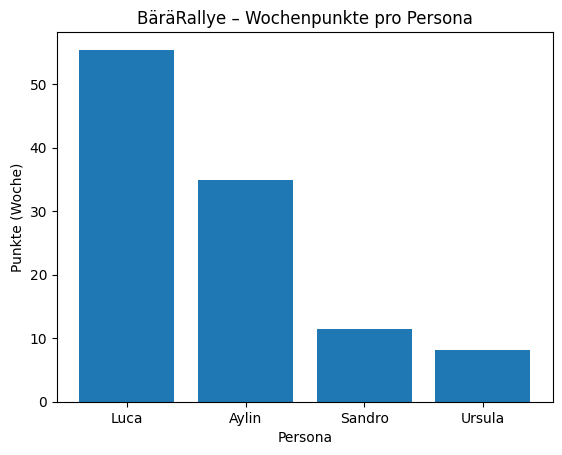

In [18]:
plt.figure()
plt.bar(weekly_totals['user'], weekly_totals['total_points'])
plt.xlabel('Persona')
plt.ylabel('Punkte (Woche)')
plt.title('BäräRallye – Wochenpunkte pro Persona')
plt.show()

### 7.2 CO₂-Ersparnis pro Persona (kg)

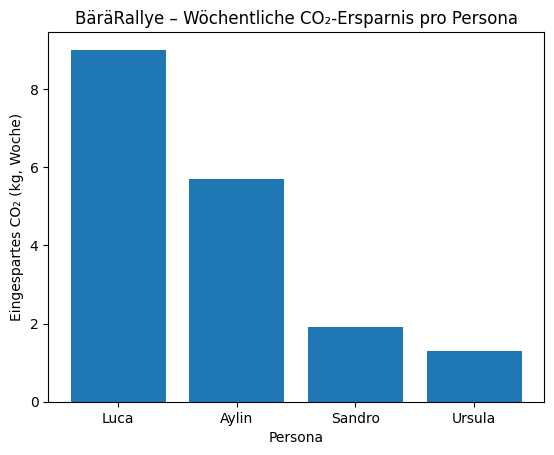

In [19]:
plt.figure()
plt.bar(weekly_totals['user'], weekly_totals['total_co2_saved_kg'])
plt.xlabel('Persona')
plt.ylabel('Eingespartes CO₂ (kg, Woche)')
plt.title('BäräRallye – Wöchentliche CO₂-Ersparnis pro Persona')
plt.show()

### 7.3 Gefahrene Kilometer pro Persona

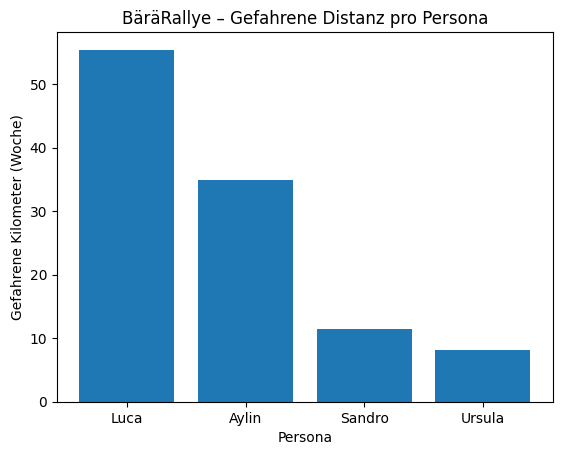

In [20]:
plt.figure()
plt.bar(weekly_totals['user'], weekly_totals['total_km'])
plt.xlabel('Persona')
plt.ylabel('Gefahrene Kilometer (Woche)')
plt.title('BäräRallye – Gefahrene Distanz pro Persona')
plt.show()